In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from fractions import Fraction
import itertools

import numpy as np
import numpy.typing as npt
import scipy.linalg as linalg
from scipy import signal
from scipy.interpolate import CubicSpline
import scipy.fft as fft
import scipy.constants as constants
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import drama.io.cfg as cfg
import drama.orbits.keplerian as d_kep
import drama.constants as d_constants
import drama.geo.geometry as d_geo
import drama.geo.swath_geo as d_swath_geo
import stereoid.utils.config as st_config
import stereoid.oceans.tops_model as TOPS
from stereoid.oceans.radar_model import ObsGeo, RadarModel
import stereoid.oceans.tools.observation_tools as obs_tools
import stereoid.sar_performance as sar_perf

In [2]:
path_to_results = Path(
    "~/Code/stereoid_public/stereoid_inputs_and_outputs/RESULTS/Scenarios/California/SWAN"
).expanduser()
path_to_nrcs = (
    path_to_results
    / "nrcs_L1_All_obs_California_T01_SWAN_350_x_050_300_y_350_650_rot_0_05.nc"
)

In [3]:
user_cfg_path = (
    Path("~/Code/stereoid_public/stereoid_inputs_and_outputs/PAR/").expanduser()
    / "user.cfg"
)
# path to PAR file
# Set this to the directory of your data and model results
paths = st_config.parse(user_cfg_path, section="Paths")
parfile = paths["par"] / f"Hrmny_2021_1.cfg"
par_data = cfg.ConfigFile(parfile)

/home/andreas/Code/stereoid_public/stereoid /home/andreas/Code/stereoid_public/stereoid_inputs_and_outputs/PAR/user.cfg


In [4]:
with xr.open_dataset(path_to_nrcs) as nrcs_ds:
    latitude = nrcs_ds.latitude.isel(grg=0)
    inc = nrcs_ds.inc

In [5]:
nrcs = xr.open_dataset(path_to_nrcs)

In [6]:
parameters = TOPS.tops_parameters(latitude, user_cfg_path, "Hrmny_2021_1.cfg")

/home/andreas/Code/stereoid_public/stereoid /home/andreas/Code/stereoid_public/stereoid_inputs_and_outputs/PAR/user.cfg


In [7]:
parameters.mean_ground_rectilinear_v()

7163.175727155044

In [8]:
tops_acqs = TOPS.TOPSAcquisitions(parameters, 0)

In [9]:
nrcs_iw1 = tops_acqs.extract_subswath(nrcs, 1)

In [10]:
nrcs_iw1

<xarray.Dataset>
Dimensions:    (az: 300, grg: 87, sat: 3, pol: 2)
Coordinates:
  * az         (az) float32 0.0 1e+03 2e+03 3e+03 ... 2.97e+05 2.98e+05 2.99e+05
  * grg        (grg) float32 3.676e+05 3.686e+05 ... 4.526e+05 4.536e+05
  * sat        (sat) <U2 'S1' 'HA' 'HB'
  * pol        (pol) <U1 'm' 'M'
Data variables:
    nrcs       (az, grg, sat, pol) float32 0.0002571 0.06503 ... 0.001203 0.0192
    longitude  (az, grg) float32 -125.8 -125.8 -125.8 ... -126.7 -126.7 -126.7
    latitude   (az, grg) float32 35.62 35.62 35.63 35.63 ... 38.33 38.34 38.34
    inc        (grg, sat, az) float32 0.5388 0.5388 0.5388 ... 0.7613 0.7613
    bist_ang   (grg, sat, az) float32 0.0 0.0 0.0 ... -0.5942 -0.5942 -0.5942
Attributes: (12/17)
    created_time:            2023-11-22T12:10:51Z
    description:             L1 for Harmony project build using stereoid tools
    incident_angle:          29
    rx_ipc_name:             tud_2020_tripple_ati
    rx_cpc_name:             tud_2020_tripple
    mode:                    IWS
    ...                      ...
    lambda_max:              500
    n_k:                     128
    fetch:                   100000.0
    SAR_spectra_lambda_max:  2000
    SAR_spectra_looks:       25
    subswath_number:         1

In [11]:
nrcs_resampled = nrcs_iw1.nrcs.to_numpy()
grg = nrcs_iw1.grg.to_numpy()
az = nrcs_iw1.az.to_numpy()
nrcs_resampled, az_new = signal.resample(
    nrcs_resampled, nrcs_resampled.shape[0] * 10, t=az, axis=0
)
nrcs_resampled, grg_new = signal.resample(
    nrcs_resampled, nrcs_resampled.shape[1] * 10, t=grg, axis=1
)

In [12]:
nrcs_up = nrcs_iw1.drop_vars("nrcs")
nrcs_up = nrcs_up.interp(
    grg=grg_new,
    az=az_new,
    method="linear",
    kwargs={"fill_value": "extrapolate"},
)
nrcs_up = nrcs_up.assign(nrcs=(["az", "grg", "sat", "pol"], nrcs_resampled))
nrcs_up.assign_attrs(
    resolution=500, resolution_units="m", posting=100, posting_units="m"
)

<xarray.Dataset>
Dimensions:    (az: 3000, grg: 870, sat: 3, pol: 2)
Coordinates:
  * sat        (sat) <U2 'S1' 'HA' 'HB'
  * pol        (pol) <U1 'm' 'M'
  * grg        (grg) float64 3.676e+05 3.677e+05 ... 4.544e+05 4.545e+05
  * az         (az) float64 0.0 100.0 200.0 ... 2.997e+05 2.998e+05 2.999e+05
Data variables:
    longitude  (az, grg) float64 -125.8 -125.8 -125.8 ... -126.7 -126.7 -126.7
    latitude   (az, grg) float64 35.62 35.62 35.62 35.62 ... 38.35 38.35 38.35
    inc        (grg, sat, az) float64 0.5388 0.5388 0.5388 ... 0.762 0.762 0.762
    bist_ang   (grg, sat, az) float64 0.0 0.0 0.0 ... -0.5934 -0.5934 -0.5934
    nrcs       (az, grg, sat, pol) float32 0.0002571 0.06503 ... 0.001735 0.0306
Attributes: (12/21)
    created_time:            2023-11-22T12:10:51Z
    description:             L1 for Harmony project build using stereoid tools
    incident_angle:          29
    rx_ipc_name:             tud_2020_tripple_ati
    rx_cpc_name:             tud_2020_tripple
    mode:                    IWS
    ...                      ...
    SAR_spectra_looks:       25
    subswath_number:         1
    resolution:              500
    resolution_units:        m
    posting:                 100
    posting_units:           m

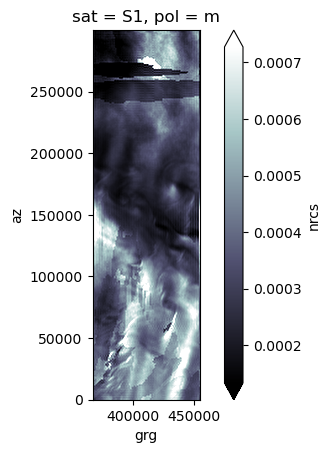

In [13]:
im = nrcs_up.sel(sat="S1", pol="m").nrcs.plot(cmap="bone", robust=True)
im.axes.set_aspect("equal")

In [14]:
mosaic_iw1 = tops_acqs.mosaic(nrcs_up, 4, False)

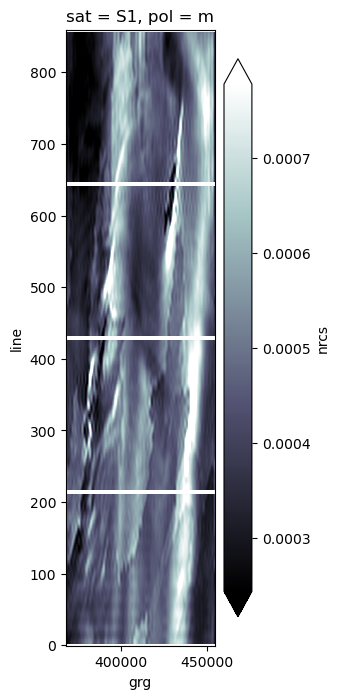

In [15]:
im = mosaic_iw1.sel(sat="S1", pol="m").nrcs.plot(
    cmap="bone", robust=True, size=8, aspect=0.3
)

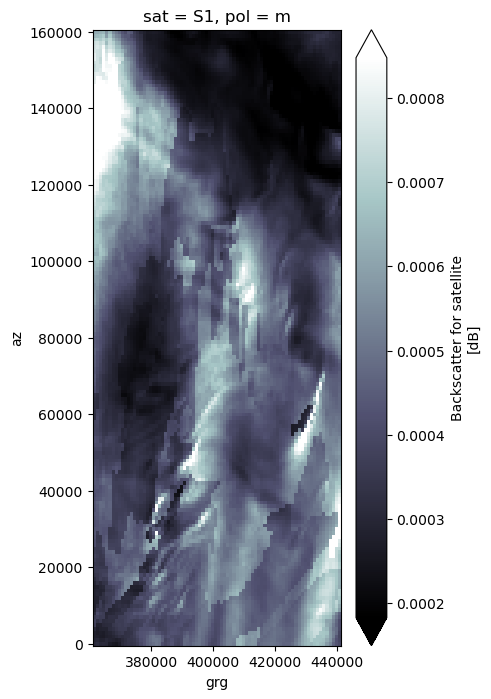

In [16]:
nrcs.sel(sat="S1", pol="m").isel(grg=slice(20, 100)).sel(
    az=slice(0, 160e3)
).nrcs.plot.imshow(
    cmap="bone", origin="lower", interpolation="none", robust=True, size=8, aspect=0.5
)

In [17]:
b1_iw1 = tops_acqs.get_burst(nrcs_up, 1, False)
b1_500 = tops_acqs.get_burst(nrcs_iw1, 1, False)

In [18]:
b1_iw1

<xarray.Dataset>
Dimensions:       (az: 215, grg: 870, sat: 3, pol: 2)
Coordinates:
  * sat           (sat) <U2 'S1' 'HA' 'HB'
  * pol           (pol) <U1 'm' 'M'
  * grg           (grg) float64 3.676e+05 3.677e+05 ... 4.544e+05 4.545e+05
  * az            (az) float64 0.0 100.0 200.0 ... 2.12e+04 2.13e+04 2.14e+04
    azimuth_time  (az) float64 0.0 0.01396 0.02792 0.04188 ... 2.96 2.974 2.988
Data variables:
    longitude     (az, grg) float64 -125.8 -125.8 -125.8 ... -125.1 -125.1
    latitude      (az, grg) float64 35.62 35.62 35.62 ... 36.18 36.18 36.18
    inc           (grg, sat, az) float64 0.5388 0.5388 0.5388 ... 0.762 0.762
    bist_ang      (grg, sat, az) float64 0.0 0.0 0.0 ... -0.5934 -0.5934 -0.5934
    nrcs          (az, grg, sat, pol) float32 0.0002571 0.06503 ... 0.03942
    sensing_time  (az) float64 0.0 0.003816 0.007632 ... 0.809 0.8128 0.8166
    mask_demarc   (az) bool True True True False False ... False True True True
Attributes: (12/22)
    created_time:             2023-11-22T12:10:51Z
    description:              L1 for Harmony project build using stereoid tools
    incident_angle:           29
    rx_ipc_name:              tud_2020_tripple_ati
    rx_cpc_name:              tud_2020_tripple
    mode:                     IWS
    ...                       ...
    subswath_number:          1
    azimuth_overlap_length:   1575.8986599741097
    first_zdt:                0.0
    last_zdt:                 3.0
    first_line_sensing_time:  0.0
    last_line_sensing_time:   0.82

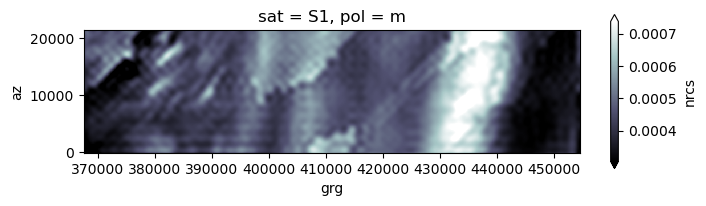

In [19]:
im = b1_iw1.sel(sat="S1", pol="m").nrcs.plot(cmap="bone", robust=True, size=2, aspect=4)
im.axes.set_aspect("equal")

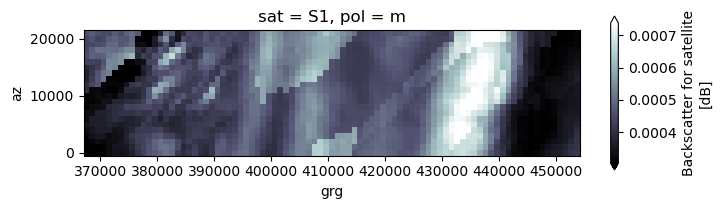

In [20]:
im = b1_500.sel(sat="S1", pol="m").nrcs.plot(
    cmap="bone", robust=True, size=2, aspect=4
)
im.axes.set_aspect("equal")

In [21]:
rng = np.random.default_rng()

In [693]:
num_samples = 2000
fs = 1000
Ts = 1 / fs
time_phase = np.linspace(0, num_samples * Ts, num_samples, endpoint=False)

In [694]:
P = np.zeros(num_samples)
n0 = int(np.floor(num_samples / 2)) + 1
shifted_freq = fft.fftshift(fft.fftfreq(num_samples, 1 / fs))
freq_mask = (shifted_freq <= 2) & (shifted_freq >= -2)
P[freq_mask] = 6 / (np.sum(freq_mask) * fs / num_samples)
phase = rng.uniform(0, 2 * np.pi, num_samples)
A = np.sqrt(num_samples * fs * P) * np.exp(1j * phase)
A[1 : n0 - 1] = np.flipud(np.conj(A[n0:]))
A[0] = np.abs(A[0])
A[n0 - 1] = P[n0 - 1]
phase_error = fft.ifft(fft.ifftshift(A))

In [695]:
phase_error = np.real(phase_error)

In [696]:
time_v = b1_iw1.sensing_time

In [697]:
phase_error_intrp = np.interp(time_v, time_phase, phase_error)

In [698]:
decim_up_ratio = Fraction(
    np.round(float((time_v[1] - time_v[0]) / Ts), 4)
).limit_denominator()
decim_factor, up_factor = decim_up_ratio.numerator, decim_up_ratio.denominator

In [699]:
phase_error_rsmp = signal.resample_poly(
    phase_error, up_factor, decim_factor, padtype="smooth"
)

In [700]:
time_rsmp = np.linspace(0, time_phase[-1], len(phase_error_rsmp), endpoint=True)

In [701]:
spl = CubicSpline(time_phase, phase_error)
phase_error_spl = spl(time_rsmp)

In [702]:
dt_rsmp = time_rsmp[1] - time_rsmp[0]

In [703]:
spl = CubicSpline(latitude, parameters.r_s)
r_sl_b1 = spl(b1_iw1.latitude.isel(grg=0))

In [704]:
Ka = (
    2
    * parameters.mean_ground_rectilinear_v() ** 2
    * par_data.sar.f0
    / (constants.c * r_sl_b1)
)

In [705]:
look_1_centre_time = par_data.IWS.proc_bw[0] * 0.25 / Ka
mean_look_1_centre_time = np.mean(look_1_centre_time)

In [706]:
mean_look_central_time = np.mean(par_data.IWS.proc_bw[0] * 0.5 / Ka)

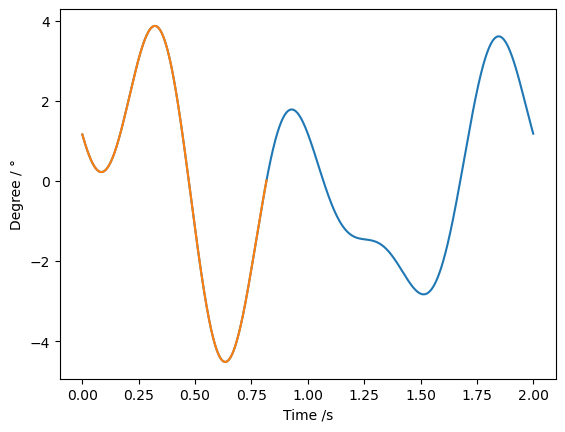

In [707]:
fig, ax = plt.subplots()
ax.plot(time_phase, phase_error)
ax.set_xlabel("Time /s")
ax.set_ylabel("Degree / °")
ax.plot(time_v, phase_error_intrp)

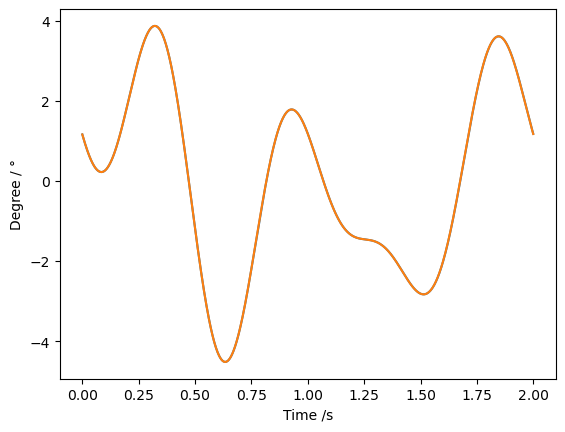

In [708]:
fig, ax = plt.subplots()
ax.plot(time_phase, phase_error)
ax.set_xlabel("Time /s")
ax.set_ylabel("Degree / °")
ax.plot(
    time_rsmp,
    phase_error_rsmp,
)

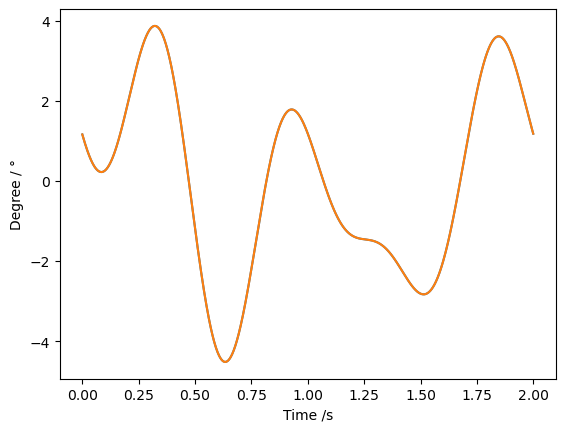

In [709]:
fig, ax = plt.subplots()
ax.plot(time_phase, phase_error)
ax.set_xlabel("Time /s")
ax.set_ylabel("Degree / °")
ax.plot(
    time_rsmp,
    phase_error_spl,
)

In [710]:
fs_interp = float(1 / (time_v[1] - time_v[0]))

In [711]:
f_interp, psd_interp = signal.periodogram(phase_error_intrp, fs_interp)
f_error, psd_error = signal.periodogram(phase_error, fs)
f_rsmp, psd_rsmp = signal.periodogram(phase_error_rsmp, fs / decim_up_ratio)
f_spl, psd_spl = signal.periodogram(phase_error_spl, fs / decim_up_ratio)

In [712]:
fig, axs = plt.subplots(1, 4, sharey=True)
axs[0].plot(f_error[0:20], psd_error[0:20])
axs[0].set_ylabel("PSD / deg^2/Hz")
axs[0].set_xlabel("Frequency /Hz")
axs[1].plot(f_interp[0:10], psd_interp[0:10])
axs[1].set_xlabel("Frequency /Hz")
axs[2].plot(f_rsmp[0:20], psd_rsmp[0:20])
axs[2].set_xlabel("Frequency /Hz")
axs[3].plot(f_spl[0:20], psd_spl[0:20])
axs[3].set_xlabel("Frequency /Hz")

Text(0.5, 0, 'Frequency /Hz')

Prepend an offset to the phase_error of the full resolution phase error for the shift of the early look.

In [713]:
phase_error_b1 = phase_error_rsmp[:len(time_v)]

In [714]:
# spl = CubicSpline(time_phase, phase_error)
# phase_error_b1 = spl(time_v)

In [715]:
phase_ds = np.zeros_like(b1_iw1.nrcs)
phase_ds += phase_error_b1[:, np.newaxis, np.newaxis, np.newaxis]
b1_iw1 = b1_iw1.assign(phase_error=(("line", "grg", "sat", "pol"), phase_ds))

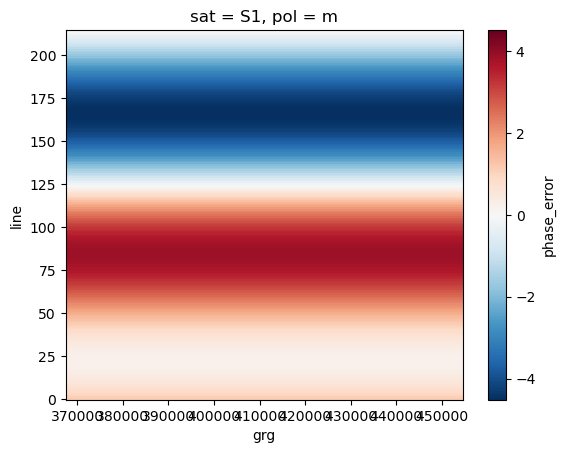

In [716]:
b1_iw1.sel(sat="S1", pol="m").phase_error.plot()

In [717]:
def sinc_interpolation(x: npt.NDArray, s: npt.NDArray, u: npt.NDArray) -> npt.NDArray:
    """Whittaker–Shannon interpolation.
    Args:
        x (NDArray): signal to be interpolated, can be 1D or 2D
        s (NDArray): time points of x (*s* for *samples*) 
        u (NDArray): time points of y (*u* for *upsampled*)
    Returns:
        NDArray: interpolated signal at time points *u*
    """
    sinc_kernel = np.sinc((u - s[:, np.newaxis])/(s[1]-s[0]))

    return np.dot(x, sinc_kernel)

In [718]:
time_phase_b1 = time_rsmp[:len(time_v)]
time_phase_l1 = time_phase_b1 - mean_look_1_centre_time / 2

In [719]:
# time_phase_l1 = time_rsmp - mean_look_1_centre_time

In [720]:
# time_phase_l1 = time_rsmp - (mean_look_1_centre_time / 2)

In [721]:
spl = CubicSpline(time_rsmp, phase_error_rsmp, extrapolate=True)
phase_error_b1_l1 = spl(time_phase_l1)
phase_error_b1_l1_f = signal.convolve(phase_error_b1_l1, np.ones(2)/2, mode="valid")
# phase_error_b1_l1_f = np.append(phase_error_b1_l1[0], phase_error_b1_l1_f)

In [722]:
fig, ax = plt.subplots()
ax.plot(time_phase, phase_error)
ax.set_xlabel("Time /s")
ax.set_ylabel("Degree / °")
ax.plot(
    time_phase_b1,
    phase_error_b1,
)
ax.plot(time_phase_l1[:-1], phase_error_b1_l1_f)

In [723]:
phase_error_b1_l1_f = np.zeros_like(b1_iw1.nrcs.isel(az=slice(None, -1), pol=0, sat=0)) + phase_error_b1_l1_f[:, np.newaxis]

In [724]:
phase_error_l1_da = xr.DataArray(phase_error_b1_l1_f, coords=[time_phase_l1[:-1], b1_iw1.grg], dims=["sensing_time", "grg"])

In [725]:
look_2_centre_time = par_data.IWS.proc_bw[0] * 0.75 / Ka
mean_look_2_centre_time = np.mean(look_2_centre_time)
time_phase_l2 = time_phase_b1 + (mean_look_2_centre_time - mean_look_central_time) / 2

In [726]:
# time_phase_l2 = time_rsmp + (mean_look_2_centre_time - mean_look_central_time)

In [727]:
# time_phase_l2 = time_rsmp + (mean_look_2_centre_time - mean_look_central_time) / 2

In [728]:
phase_error_b1_l2 = spl(time_phase_l2)
phase_error_b1_l2_f = signal.convolve(phase_error_b1_l2, np.ones(2)/2, mode="valid")
# phase_error_b1_l2_f = np.append(phase_error_b1_l2[0], phase_error_b1_l2_f)

In [729]:
fig, ax = plt.subplots()
ax.plot(time_phase, phase_error)
ax.set_xlabel("Time /s")
ax.set_ylabel("Degree / °")
ax.plot(
    time_phase_l2,
    phase_error_b1_l2,)

In [730]:
phase_error_b1_l2_f = np.zeros_like(b1_iw1.nrcs.isel(az=slice(None, -1), pol=0, sat=0)) + phase_error_b1_l2_f[:, np.newaxis]
phase_error_l2_da = xr.DataArray(phase_error_b1_l2_f, coords=[time_phase_l2[:-1], b1_iw1.grg], dims=["sensing_time", "grg"])

In [731]:
phase_error_l1_l2 = phase_error_l2_da.to_numpy() - phase_error_l1_da.to_numpy()

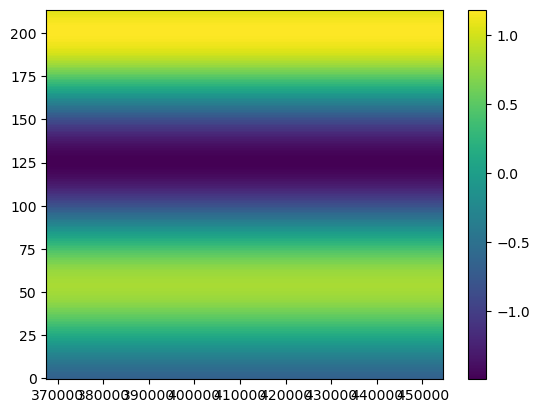

In [732]:
fig, ax = plt.subplots()
im = ax.pcolormesh(b1_iw1.grg, b1_iw1.line[:-1], phase_error_l1_l2)
fig.colorbar(im, ax=ax)

Lets's estimate the error from the derivative

In [733]:
dt_looks = time_phase_l2[0] - time_phase_l1[0]

In [734]:
dt_looks

0.034940885847719275

In [735]:
dt = float(time_v[1]) - float(time_v[0])

In [736]:
b1_der = np.diff(phase_error_b1) / dt
b1_looks_der = (phase_error_b1_l2 - phase_error_b1_l1)[1:-1] / dt_looks

In [737]:
# np.mean((b1_der - b1_looks_der)**2)

In [738]:
phase_error_b1_pad = np.zeros_like(phase_error_rsmp)
phase_error_b1_pad[:len(phase_error_b1)] = phase_error_b1
phase_error_der_b1_pad = np.zeros(len(phase_error_rsmp)-2)
phase_error_der_b1_pad[:len(b1_looks_der)] = b1_looks_der

In [739]:
# phase_error_b1_pad = phase_error_b1
# phase_error_der_b1_pad = b1_looks_der

In [740]:
phase_error_b1_pad = phase_error_rsmp
phase_error_der_b1_pad = b1_looks_der

In [741]:
beta = 100_000

In [742]:
num_rows = len(phase_error_der_b1_pad)
num_cols = len(phase_error_b1_pad)
delta = np.zeros((num_rows, num_cols))
difference_kernel = np.array([-1, 0, 1]) / (2*dt)
for i in range(num_rows):
    delta[i, i:i+3] = difference_kernel
delta_sq = delta.T @ delta

In [743]:
I = np.identity(len(phase_error_b1_pad))
A = (I + beta * delta_sq)

In [744]:
x_est = linalg.solve(A, beta * delta.T @ phase_error_der_b1_pad)

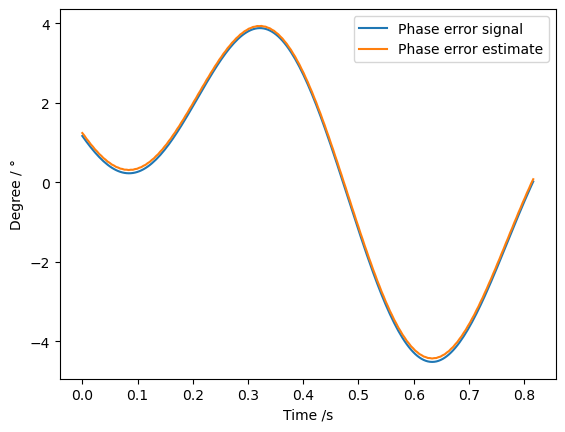

In [749]:
fig, ax = plt.subplots()
ax.set_xlabel("Time /s")
ax.set_ylabel("Degree / °")
ax.plot(
    time_phase_b1,
    phase_error_b1[:len(time_phase_b1)],
    label="Phase error signal"
)
ax.plot(time_phase_b1, x_est[:len(time_phase_b1)], label="Phase error estimate")
ax.legend()

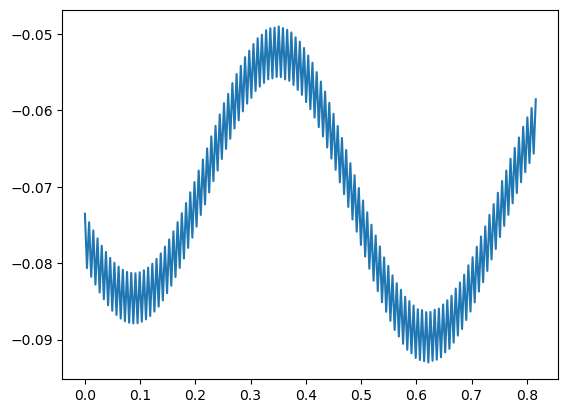

In [746]:
fig, ax = plt.subplots()
ax.plot(time_phase_b1, phase_error_b1 - x_est[:len(time_phase_b1)])

In [747]:
np.mean((x_est[:len(time_phase_b1)] - phase_error_b1)**2)

0.005499856885965871

In [748]:
np.mean((x_est - phase_error_b1)**2)

ValueError: operands could not be broadcast together with shapes (525,) (215,) 

In [ ]:
np.mean((x_est - phase_error_b1)**2)

3.9141545501599153